In [1]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
from torch import nn
from torch.utils.data import dataset
import importlib
import sys
sys.path.append("../")
import ES.ES_classes
import ES.ES_NeuralGraph
importlib.reload(ES.ES_classes)
importlib.reload(ES.ES_NeuralGraph)
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

c:\Users\bunna\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
with open("tokipona.txt") as f:
    raw_data = f.read()

punctuation = "!,.:?\""
for c in punctuation:
    raw_data = raw_data.replace(c, "")

raw_data = raw_data.replace("\n", " ")

tokens = [word for word in raw_data.split(" ") if word != ""]

# Gonna commit a slight sin and get vocab before splitting to train/test cause I don't want to bother with <unk> token

vocab, densities = np.unique(tokens, return_counts=True)
densities = densities / np.sum(densities)
vocab = vocab[np.argsort(densities)[::-1]]# [:100]
densities = np.sort(densities)[::-1]# [:100]
vocab_size = len(vocab)

print(f"Percent of language: {100*np.sum(densities):.1f}%")

stoi = {word:i for i, word in enumerate(vocab)}
itos = {i:word for i, word in enumerate(vocab)}

Percent of language: 100.0%


In [9]:
print(len(tokens))

42856


In [10]:
split = .7

train = tokens[:int(len(tokens)*split)]
valid = tokens[int(len(tokens)*split):int(len(tokens)*(split+(1-split)/2))]
test = tokens[int(len(tokens)*(split+(1-split)/2)):]

print(len(train), len(valid), len(test))

train_data = torch.Tensor([stoi[token] for token in train if token in stoi.keys()]).to(device).long()
valid_data = torch.Tensor([stoi[token] for token in valid if token in stoi.keys()]).to(device).long()
test_data = torch.Tensor([stoi[token] for token in test if token in stoi.keys()]).to(device).long()

29999 6428 6429


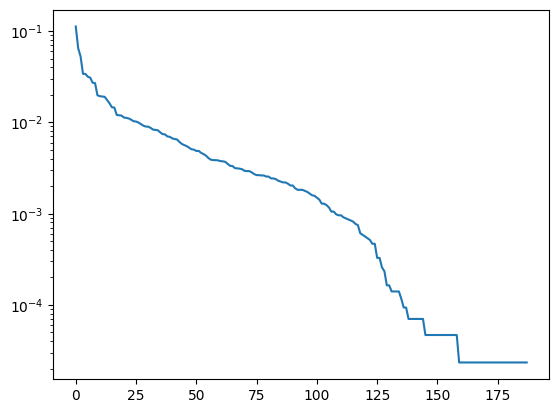

In [11]:
# ~Zipfs law
plt.yscale("log")
plt.plot(densities)

In [12]:
def get_batch(source, batch_size, bptt):
    starts = torch.randint(len(source) - bptt - 1, size=(batch_size,)).to(device)
    data = torch.stack([source[start:start+bptt+1] for start in starts], axis=0)
    x_batch = data[:, :-1]
    y_batch = data[:, 1:]
    return x_batch, y_batch

In [13]:
x_batch, y_batch = get_batch(train_data, 32, 16)

print(x_batch.shape, y_batch.shape)

torch.Size([32, 16]) torch.Size([32, 16])


In [14]:
# Shuffles up which tokens map to which indices cuz I'm evil and want to torture the ngraph >:)
def shuffle_lang(x_batch, y_batch):
    batch_size = x_batch.shape[0]
    
    reordering = torch.stack([torch.randperm(vocab_size) for _ in range(batch_size)]).to(device)

    x_batch = torch.stack([reordering[i][x_batch[i]] for i in range(batch_size)])
    y_batch = torch.stack([reordering[i][y_batch[i]] for i in range(batch_size)])
    return x_batch, y_batch, reordering

In [44]:
ch_n = 8
ch_e = 8
ch_n_const = 2 # Flag for inp and out node
ch_inp = 1
ch_out = 1

emb_size = 16
# Totally Random embeddings
# enc = torch.randn(vocab_size, emb_size).to(device)
# dec = torch.linalg.pinv(enc)

In [52]:
n_inp = emb_size
n_hid = 16
n_out = emb_size

n_nodes = n_inp + n_hid + n_out

connections = [[i, j] for i in range(n_inp) for j in range(n_inp, n_inp + n_hid)] + \
    [[i, j] for i in range(n_inp, n_inp + n_hid) for j in range(n_inp, n_inp + n_hid)] + \
    [[i, j] for i in range(n_inp, n_inp + n_hid) for j in range(n_inp + n_hid, n_inp + n_hid + n_out)]

connections = torch.Tensor(connections)

print(connections.shape)

graph = ES.ES_NeuralGraph.NeuralGraph(n_nodes, n_inp, n_out, connections,
    ch_n=ch_n, ch_e=ch_e, ch_inp=ch_inp, ch_out=ch_out, ch_n_const=2, init_mode="random", init_std=.01, set_nodes=True, use_label=True,
    aggregation="mean", clamp_mode="hard", max_value=100).to(device)# inp_enc=inp_enc, out_dec=out_dec

enc = ES.ES_classes.ES_Linear(vocab_size, emb_size).to(device)
dec = ES.ES_classes.ES_Linear(emb_size, vocab_size).to(device)

optimizer = torch.optim.Adam([*graph.parameters(), *enc.parameters(), *dec.parameters()], lr=1e-3)
criterion = nn.CrossEntropyLoss(reduction='none')
sigma = .05

log = []

torch.Size([768, 2])


In [53]:
# graph.load_state_dict(torch.load("tokipona.pt"))

In [54]:
const_n=torch.zeros(n_nodes, 2).to(device)
const_n[:n_inp, 0] = 1
const_n[-n_out:, 1] = 1
graph.set_const_vals(const_n)

In [55]:
steps = 100_000
T = 5
DT = 1
batch_size = 256
bptt = 128

with torch.no_grad():

    bar = tqdm(range(1, steps+1))
    for step in bar:
            x_batch, y_batch = get_batch(train_data, batch_size, bptt)
            shuffled_x, shuffled_y, orderings = shuffle_lang(x_batch, y_batch)

            graph.generate_epsilons(batch_size, sigma=sigma)
            enc.generate_epsilons(batch_size, sigma)
            dec.generate_epsilons(batch_size, sigma)

            x_emb = enc(nn.functional.one_hot(shuffled_x, vocab_size).float())#  @ enc
            y_emb = enc(nn.functional.one_hot(shuffled_y, vocab_size).float())#  @ enc

            graph.init_vals(nodes=True, edges=True, batch_size=batch_size)

            preds = []
            for t in range(bptt):
                pred = dec(graph.forward(x_emb[:, t], T, DT, edges=False))#  @ dec
                graph.backward(x_emb[:, t], y_emb[:, t], T, DT, edges=False, edges_at_end=True)

                preds.append(pred)

            preds = torch.stack(preds, axis=1)
            # For some reason batch dims can be dim 0 and dims 2, 3, ...  NOT DIM 1
            losses = criterion(torch.swapaxes(preds, -1, -2), shuffled_y).mean(-1)
            loss = losses.mean().item()

            accs = (preds.argmax(-1) == shuffled_y).float().mean(-1)
            acc = accs.mean().item()

            overflows = torch.where(graph.nodes.abs() > 5, graph.nodes.abs(), 0).mean(-1).mean(-1) + torch.where(graph.nodes.abs() > 5, graph.nodes.abs(), 0).mean(-1).mean(-1)
            overflow = overflows.mean().item()

            graph.estimate_grads(losses - accs + overflows, sigma=sigma, normalize=True)
            enc.estimate_grads(losses - accs + overflows, sigma=sigma, normalize=True)
            dec.estimate_grads(losses - accs + overflows, sigma=sigma, normalize=True)
            
            optimizer.step()

            entry = {'loss':loss, 'acc':acc, 'overflow':overflow}
            log.append(entry)
            bar.set_postfix(entry)

  0%|          | 0/100000 [00:00<?, ?it/s]

  8%|▊         | 7595/100000 [6:14:06<75:51:40,  2.96s/it, loss=5.24, acc=0.00494, overflow=0]       


KeyboardInterrupt: 

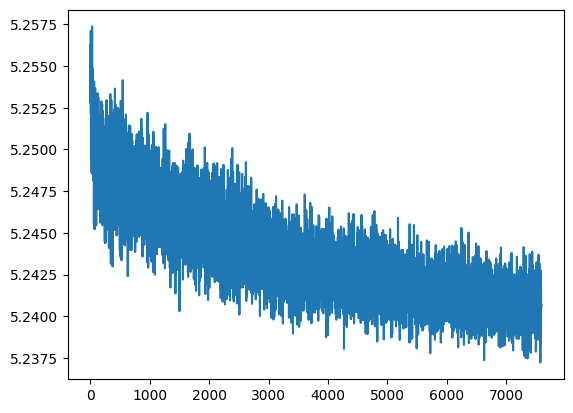

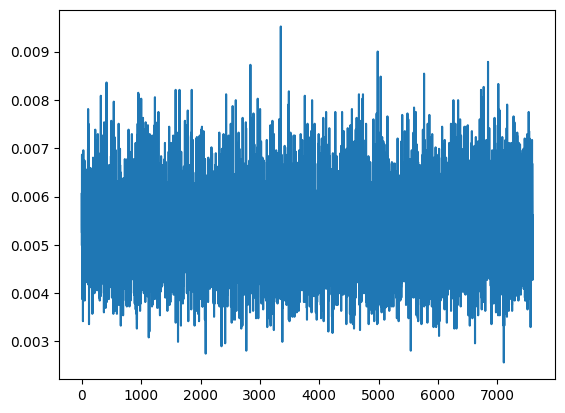

In [56]:
plt.plot([e["loss"] for e in log])
plt.show()
plt.plot([e["acc"] for e in log])
plt.show()

In [106]:
test_batch_size = 1024

with torch.no_grad():
        x_batch, y_batch = get_batch(train_data, test_batch_size, bptt)
        shuffled_x, shuffled_y, orderings = shuffle_lang(x_batch, y_batch)

        graph.generate_epsilons(test_batch_size, sigma=sigma)
        graph.init_vals(nodes=True, edges=True, batch_size=test_batch_size)

        preds = []
        for t in range(bptt):
            # Unsqueeze to represent only one input node
            pred = graph.forward(nn.functional.one_hot(shuffled_x[:, t], vocab_size), T, DT, edges=False)
            graph.backward(nn.functional.one_hot(shuffled_x[:, t], vocab_size), nn.functional.one_hot(shuffled_y[:, t], vocab_size), T, DT, edges=False, edges_at_end=True)

            preds.append(pred)

        preds = torch.stack(preds, axis=1)

        accs = (preds.argmax(-1) == shuffled_y).float().mean(0).cpu().numpy()

KeyboardInterrupt: 

In [16]:
torch.save(graph.state_dict(), "tokipona.pt")

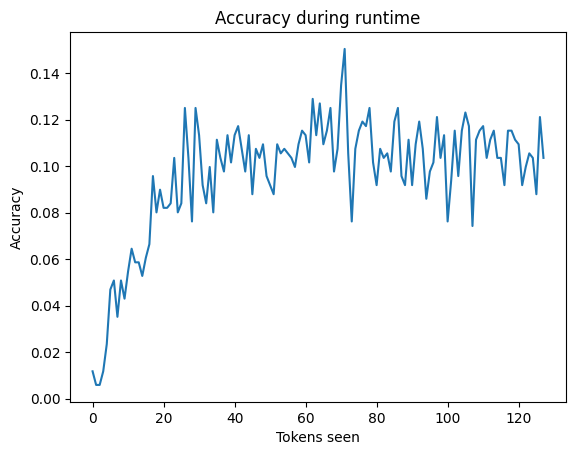

In [ ]:
plt.plot(accs)
plt.title("Accuracy during runtime")
plt.xlabel("Tokens seen")
plt.ylabel("Accuracy")
plt.show()

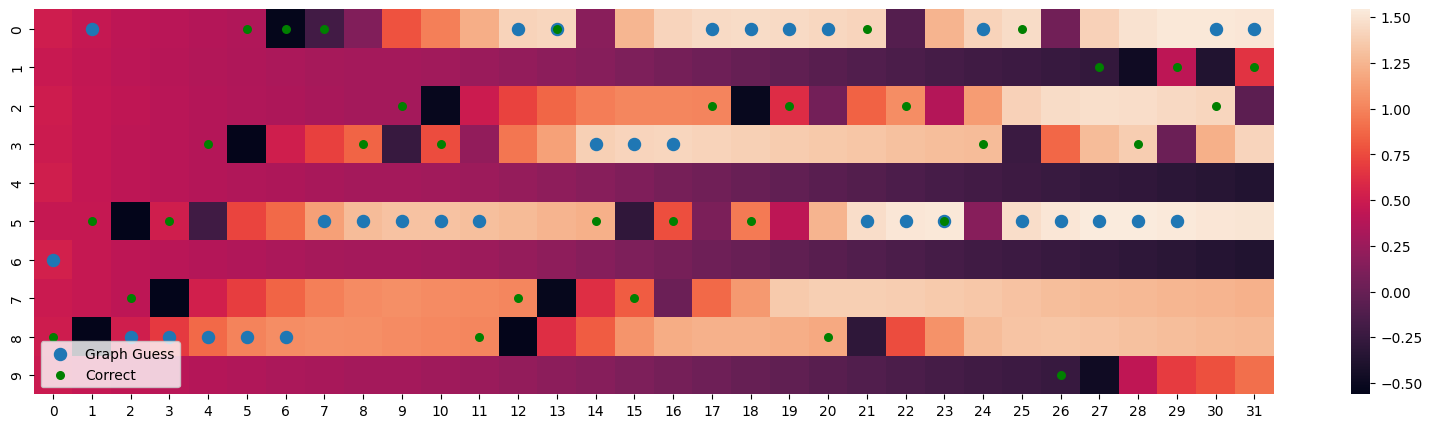

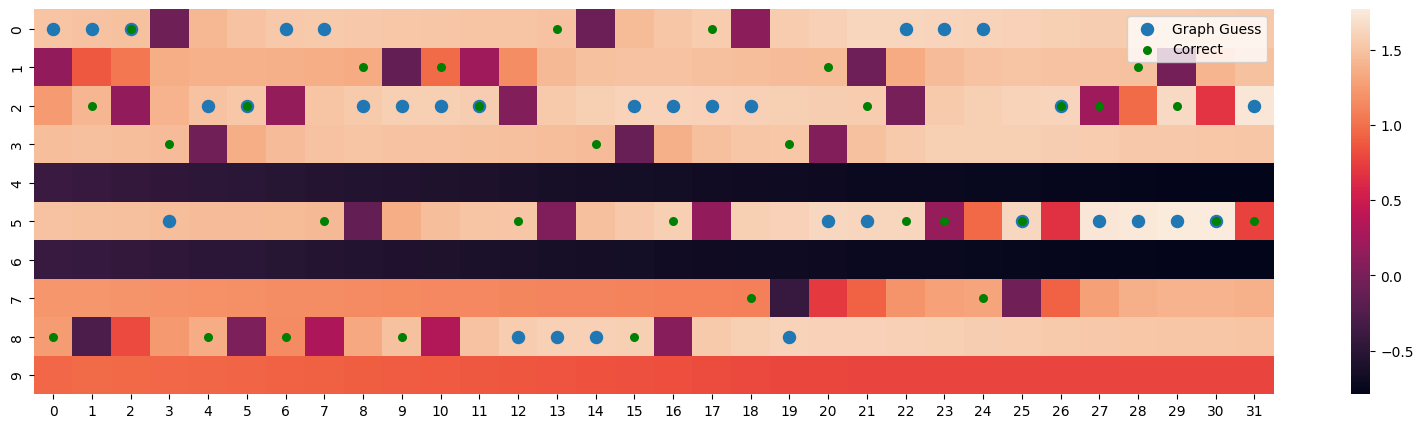

In [82]:
import seaborn as sb

i = 1

plt.figure(figsize=(20, 5))

sb.heatmap(preds[i, :32].cpu().T)

plt.scatter(np.arange(32)+.5, preds[i, :32].argmax(-1).cpu()+.5, s=75, label="Graph Guess")

plt.scatter(np.arange(32)+.5, shuffled_y[i, :32].cpu()+.5, s=30, c="green", label="Correct")

plt.legend()

plt.show()

plt.figure(figsize=(20, 5))

sb.heatmap(preds[i, 32:].cpu().T)

plt.scatter(np.arange(32)+.5, preds[i, 32:].argmax(-1).cpu()+.5, s=75, label="Graph Guess")

plt.scatter(np.arange(32)+.5, shuffled_y[i, 32:].cpu()+.5, s=30, c="green", label="Correct")

plt.legend()

plt.show()

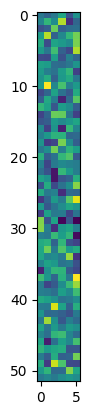

In [67]:
# plt.imshow(graph.init_edges.cpu().detach())
plt.imshow(graph.init_nodes.cpu().detach())

In [47]:
print(graph.init_nodes.shape)
print(graph.const_n.shape)

torch.Size([16, 14])
torch.Size([16, 2])


In [38]:
num_batches = train_data.shape[1] // bptt
print(num_batches)

15


In [37]:
print(train_data.shape)

torch.Size([512, 4003])
